In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

sys.path.append("..")
from utils import (
    filter_noisy_genes,
    load_model,
    read_aws_h5ad,
    set_seed,
    split_data_by_cell,
    write_adata_to_s3,
)

set_seed(0)

Seed set


## Load Model from Checkpoint

In [ ]:
# use anndata generate by ..data_processing/replogle_prior_graph_preprocessing.ipynb
unfilterd_adata = read_aws_h5ad("path to preprocessed h5ad")
adata = filter_noisy_genes(unfilterd_adata)
adata.X = adata.X.todense()
device = torch.device("cuda:0")
gene_network = adata.uns["sparse_gene_network"].todense()

In [8]:
# filter adata to perturbations with at least 50 samples
obs_df = pd.DataFrame(adata.obs["gene"])
category_counts = obs_df["gene"].value_counts()
filtered_categories = category_counts[category_counts >= 50].index
adata = adata[adata.obs["gene"].isin(filtered_categories)]

In [9]:
# get the filtered 'strong' perturbations, but do not use the limited gene expression
# references the svae filtered replogle anndata to subset to those cells (https://github.com/Genentech/sVAE/blob/main/entry_points/replogle-preprocessing.ipynb)
filtered_replogle = read_aws_h5ad("path to svae filtered replogle h5ad")
filtered_perts = set(filtered_replogle.obs["gene"].unique()).union(
    set(["SKP2", "CUL1", "UBE2N"])
)
adata = adata[adata.obs["gene"].isin(filtered_perts)]

In [ ]:
# load model from checkpoint
s3_dir = "s3://pert-spectra/PertSpectra_checkpoints/"
experiment_name = "pertspectra_replogle/"
model_name = "replogle"
wrapper, adata = load_model(
    adata=adata,
    s3_dir=s3_dir,
    experiment_name=experiment_name,
    model_name=model_name,
    use_cell_types=False,
)

In [ ]:
# save trained PertSpectra parameters
adata.uns["SPECTRA_factors"] = wrapper.factors
adata.uns["SPECTRA_L"] = wrapper.internal_model.L
adata.uns["SPECTRA_pert_scores"] = wrapper.cell_scores

In [11]:
# reconstruct binarized perturbation matrix
pert_idx = list(wrapper.internal_model.pert_idx)
pert_labels = [x.split("_")[-1] for x in wrapper.internal_model.pert_labels]
adata.uns["Spectra_pert_labels"] = pert_labels
D = []
for i in adata.obs["gene"]:
    d = [0.0 for _ in range(len(pert_idx))]
    # add intercept
    d[-1] = 1
    if i == "non-targeting":
        d[-2] = 1.0
        D.append(d)
        continue
    guides = i.split("+")

    # pert or intergenic
    one_hot_idx = pert_labels.index(guides[0])
    d[one_hot_idx] = 1.0

    if len(guides) > 1:
        one_hot_idx = pert_labels.index(guides[1])
        d[one_hot_idx] = 1.0
    D.append(d)
D = np.stack(D).astype(np.float32)

## Reconstructed Gene Expression
- Visualize reconstructed gene expression for a single perturbation
- Save reconstructed gene expression for all heldout cells

In [18]:
# wrap in cpu
wrapper.internal_model.to(torch.device("cpu"))
wrapper.internal_model.device = torch.device("cpu")

In [16]:
train_idx, val_idx, test_idx = split_data_by_cell(
    adata.X, adata.obs["gene"], test_size=0.2, val_size=0.2
)

In [17]:
holdout_perts = "RIOK2"
X_holdout = torch.from_numpy(adata.X[test_idx])
D_holdout = torch.from_numpy(D[test_idx])
loss_weights = torch.from_numpy(np.ones(X_holdout.shape[0]))

In [19]:
with torch.no_grad():
    loss, recon = wrapper.internal_model.loss_no_cell_types(
        X=X_holdout, D=D_holdout, loss_weights=loss_weights, forward=True
    )

In [20]:
mean_reconstruction = torch.mean(recon, dim=0).detach().cpu().numpy()
observed = torch.from_numpy(adata[(adata.obs["gene"] == holdout_perts)].X)
mean_observed = torch.mean(observed, dim=0).detach().cpu().numpy()

In [ ]:
from scipy.stats import spearmanr

spearmans = spearmanr(mean_reconstruction, mean_observed)

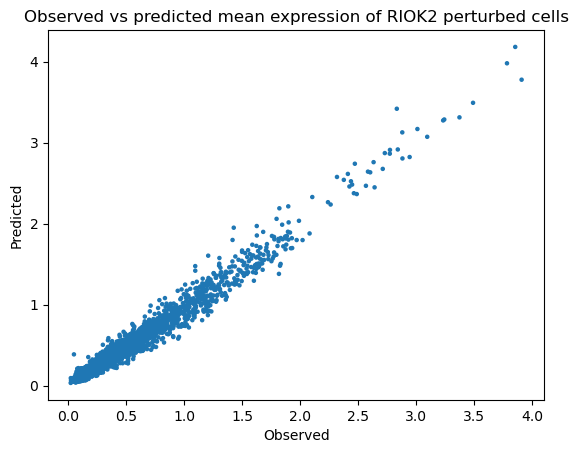

Spearman correlation: SignificanceResult(statistic=0.9748835210506989, pvalue=0.0)


In [22]:
plt.scatter(
    mean_observed, mean_reconstruction, s=[5 for _ in range(len(mean_observed))]
)
plt.title(f"Observed vs predicted mean expression of {holdout_perts} perturbed cells")
plt.ylabel("Predicted")
plt.xlabel("Observed")
plt.show()
spearmans = spearmanr(mean_reconstruction, mean_observed)
print(f"Spearman correlation: {spearmans}")

In [24]:
# get reconstruction for all heldout samples
X_holdout = torch.from_numpy(adata.X[test_idx])
D_holdout = torch.from_numpy(D[test_idx])
loss_weights = torch.from_numpy(np.ones(X_holdout.shape[0]))
recons = []
losses = []
with torch.no_grad():
    for i in range(0, len(X_holdout), 10000):
        loss, recon = wrapper.internal_model.loss_no_cell_types(
            X=X_holdout[i : i + 10000],
            D=D_holdout[i : i + 10000],
            loss_weights=loss_weights[i : i + 10000],
            forward=True,
        )
        losses.append(loss.detach().cpu().numpy())
        recons.append(recon.detach().cpu().numpy())
adata.uns["recon"] = np.concatenate(recons)
adata.uns["losses"] = np.array(losses)

## Save anndata for downstream analysis

In [29]:
# save anndata for downstream analysis
from scipy import sparse

adata.X = sparse.csr_matrix(adata.X)
write_adata_to_s3(s3_dir + experiment_name, "replogle", adata)